# Multimodal AI for Visual Question Answering (VQA) and Automated Image Captioning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**GPU Availability**
# CUDA, which stands for Compute Unified Device Architecture, is a parallel computing platform and programming model developed by NVIDIA. It allows software developers to use NVIDIA GPUs for general-purpose processing, significantly accelerating computationally intensive tasks.

In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA Available: False
CUDA Device: None


# Installing Necessary Packages
## This code snippet is responsible for installing the required Python packages using pip, the package installer for Python.

In [3]:
# Run the following commands in your terminal or uncomment below to install packages locally:
!pip install datasets==2.9.0
!pip install -U datasets fsspec

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.9.0
    Uninstalling datasets-2.9.0:
      Successfully uninstalled datasets-2.9.0
ERROR: pip's dependency resolver does not curre

# The **datasets** library, developed by Hugging Face, is a powerful tool for easily accessing, processing, and managing datasets in various formats for machine learning tasks.

In [5]:
!pip install transformers datasets evaluate --quiet

## Transformers are a type of deep learning model architecture primarily known for their effectiveness in Natural Language Processing (NLP) tasks.
# Multimodal AI
## Combining text, images, and other modalities for tasks like VQA, image captioning, and document understanding.

In [6]:
import os
from transformers import logging

# Set HuggingFace cache dir
os.environ['HF_HOME'] = os.path.join(".", "cache")
os.environ['HF_DATASETS_CACHE'] = os.path.join(".", "cache")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Set transformer logging level
logging.set_verbosity_error()

In [7]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Prevent TF/Keras errors
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoFeatureExtractor,
    AutoModel, TrainingArguments, Trainer, logging
)
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset  # Removed set_caching_enabled

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cpu


# **Load the Processed DAQUAR Dataset** (DAtaset for QUestion Answering on Real-world images (DAQUAR) dataset)
## All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (answer space) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [9]:
from datasets import load_dataset
import os

# Mount Google Drive (uncomment if not mounted yet)
from google.colab import drive
drive.mount('/content/drive')

# Define Google Drive paths
data_dir = "/content/drive/MyDrive/DIP"
train_csv = os.path.join(data_dir, "data_train.csv")
test_csv = os.path.join(data_dir, "data_eval.csv")
answer_file = os.path.join(data_dir, "answer_space.txt")

# Load dataset from CSV files
dataset = load_dataset(
    "csv",
    data_files={
        "train": train_csv,
        "test": test_csv
    }
)

# Load answer space
with open(answer_file, "r") as f:
    answer_space = f.read().splitlines()

# Preprocess labels
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # Take the first answer
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

In [10]:
from IPython.display import display
import numpy as np
from PIL import Image
import os

# Function to return the correct local file path
def get_file_path(filename):
    base_path = "./dataset/"  # Assuming everything is in or relative to your notebook folder
    return os.path.join(base_path, filename)

# Function to show a random or specific example from train/test dataset
def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if id is None:
        id = np.random.randint(len(data))

    # Assumes images are in ./images/ and named like <image_id>.png
    image_path = get_file_path(os.path.join("images", data[id]["image_id"] + ".png"))

    # Load and display image
    image = Image.open(image_path)
    display(image)

    # Show question and answer
    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], f"(Label: {data[id]['label']})")


In [11]:
from IPython.display import display
import numpy as np
from PIL import Image
import os

# === Display a sample from train/test ===
def showExample(train=True, id=None):
    # Select the dataset split
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    # Pick a random ID if none is provided
    if id is None:
        id = np.random.randint(len(data))

    image_filename = data[id]["image_id"] + ".png"
    image_path = os.path.join("/content/drive/MyDrive/DIP/images/images", image_filename)

    # Load and display image
    try:
        image = Image.open(image_path)
        display(image)
    except FileNotFoundError:
        print(f"⚠️ Image not found at path: {image_path}")
        return

    # Print question and answer
    print("Question:\t", data[id]["question"])
    if "label" in data[id]:
        print("Answer:\t\t", data[id]["answer"], f"(Label: {data[id]['label']})")
    else:
        print("Answer:\t\t", data[id]["answer"])

# The **showExample** function is a handy tool to visualize your data by displaying a random (or specific) image from your dataset, along with its corresponding question and answer. This is useful for data exploration and understanding the content of your VQA dataset.

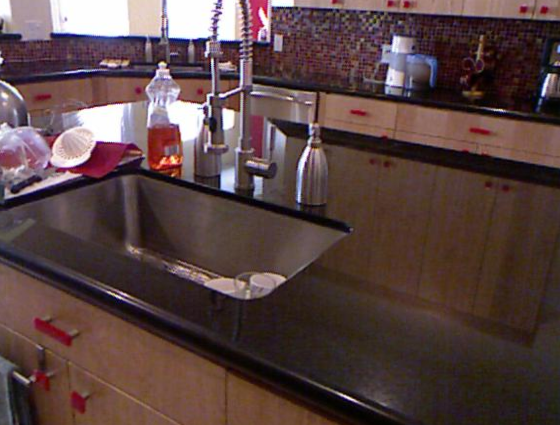

Question:	 what object is found in orange colour near the sink faucet
Answer:		 bottle_of_hand_wash_liquid (Label: 64)


In [12]:
showExample()

In [14]:
from transformers import BlipProcessor, BlipForConditionalGeneration #image captioning
from transformers import ViltProcessor, ViltForQuestionAnswering #VQA
from PIL import Image
from IPython.display import display
import torch
from evaluate import load

# **BlipForConditionalGeneration** is the actual BLIP model, specifically designed for generating image captions. BLIP stands for Bootstrapping Language-Image Pre-training, and it's a powerful model for creating descriptive captions from images.
# **ViltForQuestionAnswering** is the ViLT model itself, specialized for answering questions about images. ViLT stands for Vision-and-Language Transformer, and it's designed to understand the relationship between images and text.

In [15]:
# Captioning model: BLIP
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# VQA model: ViLT (you may already have this in your notebook)
vqa_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vqa_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

In [16]:
def generate_caption(image):
    inputs = caption_processor(images=image, return_tensors="pt")
    out = caption_model.generate(**inputs)
    caption = caption_processor.decode(out[0], skip_special_tokens=True)
    return caption

def answer_question(image, question):
    encoding = vqa_processor(image, question, return_tensors="pt")
    outputs = vqa_model(**encoding)
    logits = outputs.logits
    predicted_idx = logits.argmax(-1).item()
    return vqa_model.config.id2label[predicted_idx]

# Below part of the code creates an interactive experience where the user can upload an image, see an automatically generated caption, and ask questions about the image, receiving answers powered by the VQA model.

Please upload an image


Saving l8FEmV.jpg to l8FEmV.jpg


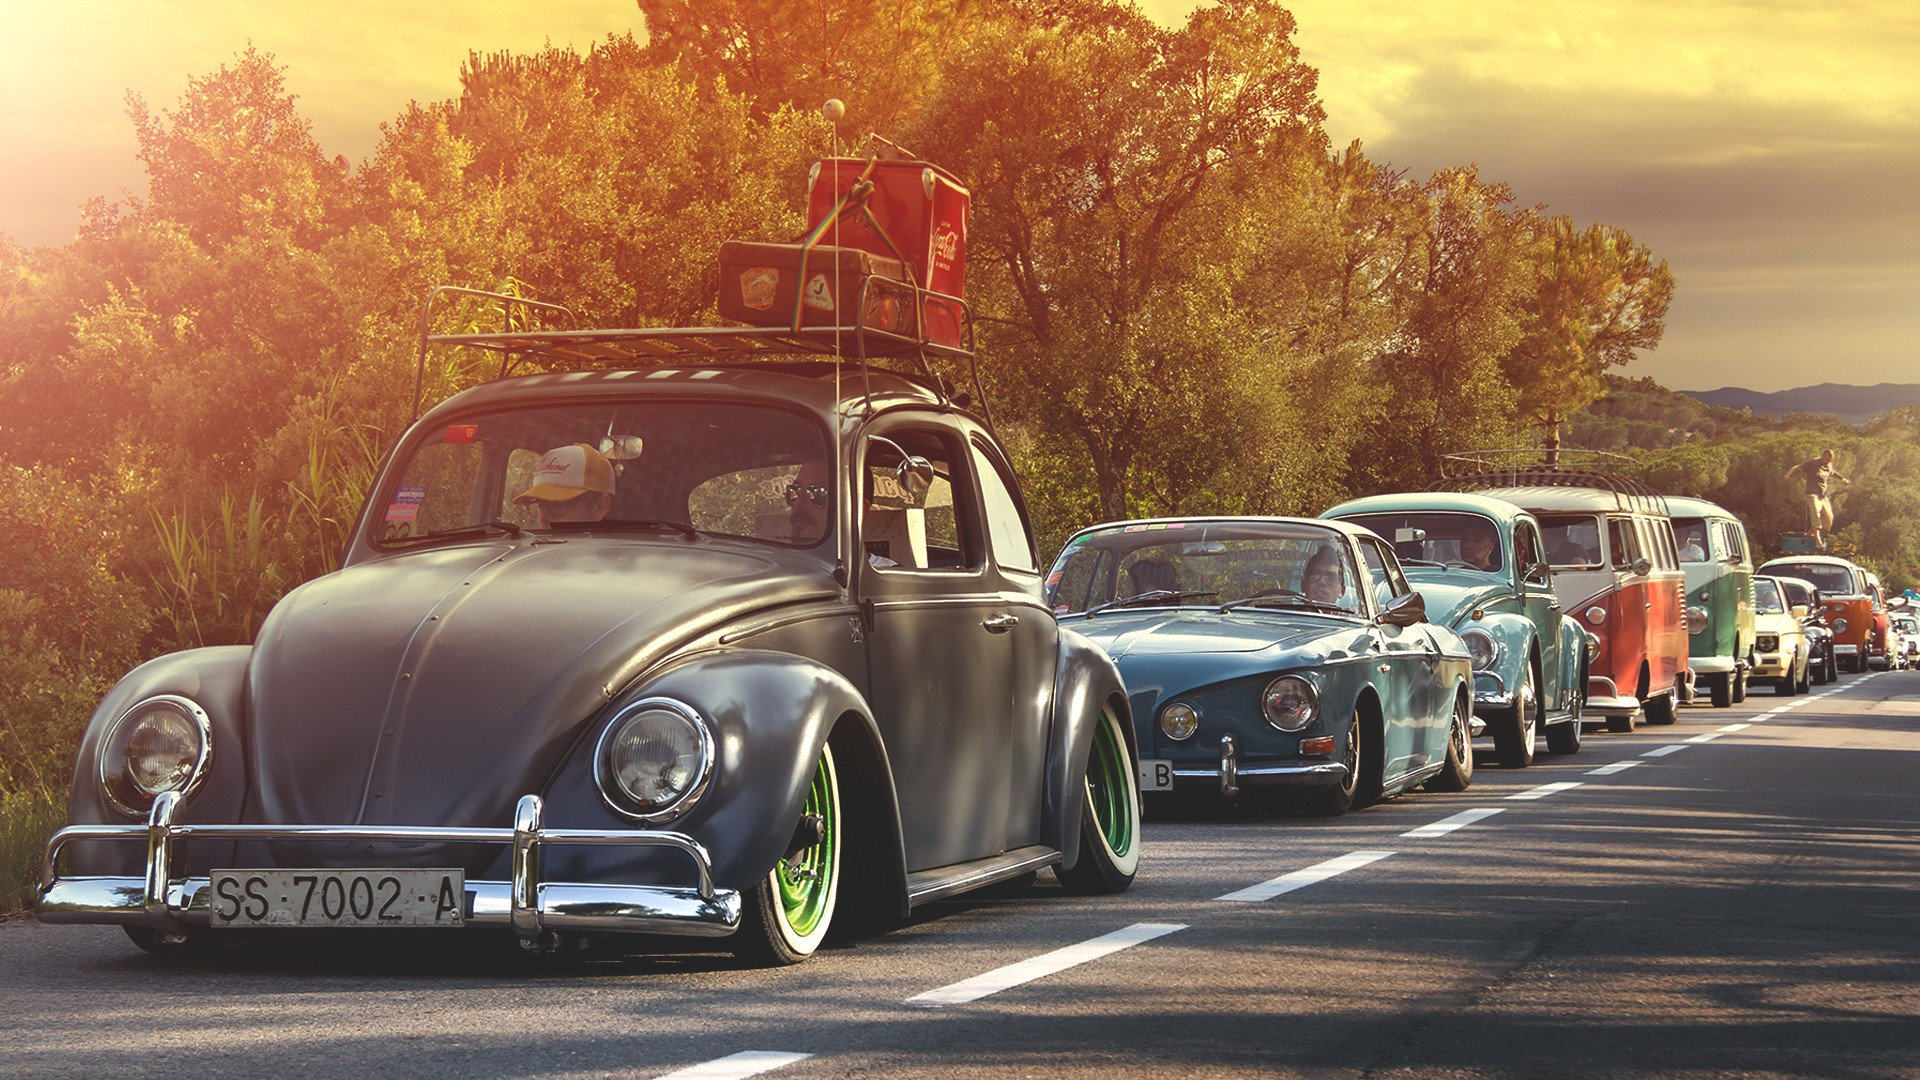


Generated Caption: a row of old cars on a road

Type your question about the image below and press Enter:


Text(value='', description='Ask:', layout=Layout(width='80%'), placeholder='e.g., What is the person doing?')

Output()

In [18]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# Step 1: Upload Image
print("Please upload an image")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
image = Image.open(img_path).convert("RGB")
display(image)

# Step 2: Auto-generate caption
caption = generate_caption(image)
print(f"\nGenerated Caption: {caption}")

# Step 3: Ask a question
question_widget = widgets.Text(
    description='Ask:',
    placeholder='e.g., What is the person doing?',
    layout=widgets.Layout(width='80%')
)

output = widgets.Output()

def on_submit(change):
    question = change.new
    answer = answer_question(image, question)
    with output:
        clear_output()
        print(f"\n Answer: {answer}")

question_widget.observe(on_submit, names='value')

print("\nType your question about the image below and press Enter:")
display(question_widget, output)
